In [1]:
import os, sys
HOME_DIR = os.path.join(os.getcwd(), '..')
sys.path.append(HOME_DIR)
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
import torch
from torch_geometric.loader import DataLoader
from substrate_metric_learning.networks import Net
from substrate_metric_learning.utils import *
from substrate_metric_learning.features import smiles_to_graph_substrate, smiles_to_graph
from rdkit.Chem import Draw
from tqdm.notebook import tqdm
import random

import sklearn


import matplotlib

def save_fig(ax,file_path):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt = ax.get_figure()
    plt.savefig(file_path, transparent=True)
    return

In [2]:
from sklearn.decomposition import PCA
from sklearn import manifold
from umap import UMAP
import sklearn


/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/dist

# Load models

In [3]:
config_path = os.path.join(HOME_DIR, "configs/hparams_default.yaml")
config = Objdict(yaml.safe_load(open(config_path)))
input_dim = 133
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1.172
model_pretrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_pretrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_56_sum_r2_1.538.pth"))
model_untrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_untrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_0.pth"))

<All keys matched successfully>

In [4]:
@torch.no_grad()
def get_embedding_from_smi(smi_list, c_index_list, model, device):
    assert len(smi_list) == len(c_index_list)
    assert model.pool_method == 'c'
    train_dataset = [smiles_to_graph_substrate(smiles=smi_list[i], s=0, y=0, atm_idx=[c_index_list[i]]) for i in range(len(smi_list))]
    loader = DataLoader(train_dataset, 128, shuffle=False)
    model.eval()
    embeddings = []
    for data in loader:
        data = data.to(device)
        _, emb = model(data.x, data.edge_index, data.batch, data.atm_idx)
        embeddings.append(emb.cpu().detach().numpy())
    return np.concatenate(embeddings, axis=0)

# Visualization

In [5]:
data_full = pd.read_csv(os.path.join(HOME_DIR, "data/arylhalide_database_w_idx.csv"))
halides = [Chem.MolFromSmiles(data_full.Arylhalide[i]).GetAtoms()[int(data_full.halide_index[i])].GetSymbol() for i in range(len(data_full))]
data_full['Halide'] = halides

data = data_full.sample(frac=0.05, random_state=42).reset_index(drop=True)

if config.pool == 'c':
    train_dataset = [smiles_to_graph_substrate(smiles=data['Arylhalide'][ind], 
                                            s=data['ScopeID'][ind], 
                                            y=data['Yield'][ind]/100, 
                                                atm_idx=[data['aroma_c_index'][ind]]) for ind in range(len(data))]
elif config.pool == 'cx':
    train_dataset = [smiles_to_graph_substrate(smiles=data['Arylhalide'][ind], 
                                            s=data['ScopeID'][ind], 
                                            y=data['Yield'][ind]/100, 
                                            atm_idx=[data['aroma_c_index'][ind], data['halide_index'][ind]]) for ind in range(len(data))]
elif config.pool == 'global':
    train_dataset = [smiles_to_graph_substrate(smiles=data['Arylhalide'][ind], 
                                            s=data['ScopeID'][ind], 
                                            y=data['Yield'][ind]/100) for ind in range(len(data))]
else:
    raise ValueError('Invalid pool type')
   

# train_dataset = torch.load(os.path.join(HOME_DIR, "data/train_dataset.ptg"))
loader = DataLoader(train_dataset, 128, shuffle=False)

embeddings_pretrained = get_embedding(model_pretrained, loader, device)
embeddings_untrained = get_embedding(model_untrained, loader, device)

In [6]:
data_full

,RxnSMILES,Arylhalide,Canonical,RxnID,Yield,ScopeID,ScopeSize,aroma_c_index,halide_index,Halide
0,C[Si](C)(C)[Si:1]([CH3:2])([CH3:3])[CH3:4].I[C...,I[C:11]1=[CH:9][CH:7]=[C:6]([Cl:5])[CH:8]=[CH:...,Clc1ccc(I)cc1,12980746,67.0,9,10,1,0,I
1,C[Si](C)(C)[Si:9]([CH3:10])([CH3:11])[CH3:12]....,I[C:6]1=[CH:4][C:2]([Cl:1])=[CH:3][C:5]([Cl:7]...,Clc1cc(Cl)cc(I)c1,12980747,65.0,9,10,1,0,I
2,C[Si](C)(C)[Si:11]([CH3:12])([CH3:13])[CH3:14]...,I[C:10]1=[CH:8][CH:6]=[C:5]([C:1]([CH3:2])([CH...,CC(C)(C)c1ccc(I)cc1,12980741,71.0,9,10,1,0,I
3,C[Si](C)(C)[Si:1]([CH3:2])([CH3:3])[CH3:4].I[C...,I[C:11]1=[CH:9][CH:7]=[C:6]([F:5])[CH:8]=[CH:10]1,Fc1ccc(I)cc1,12980744,74.0,9,10,1,0,I
4,C[Si](C)(C)[Si:9]([CH3:10])([CH3:11])[CH3:12]....,I[C:6]1=[CH:4][C:2]([CH3:1])=[CH:3][C:5]([CH3:...,Cc1cc(C)cc(I)c1,12980740,77.0,9,10,1,0,I
...,...,...,...,...,...,...,...,...,...,...
110766,Br[C:39]1=[C:41]2[C:43](=[C:45]3[C:42](=[CH:40...,Br[C:39]1=[C:41]2[C:43](=[C:45]3[C:42](=[CH:40...,Brc1cc2c3ccccc3oc2c2ccccc12,22421223,74.0,633963,2,1,0,Br
110767,I[C:29]1=[CH:30][CH:32]=[CH:34][CH:33]=[CH:31]...,I[C:29]1=[CH:30][CH:32]=[CH:34][CH:33]=[CH:31]1,Ic1ccccc1,21657609,83.0,633971,2,1,0,I
110768,Cl[C:29]1=[N:31][C:34]([C:38]2=[CH:40][CH:42]=...,Cl[C:29]1=[N:31][C:34]([C:38]2=[CH:40][CH:42]=...,Clc1nc(-c2ccccc2)nc2ccccc12,21657619,73.0,633971,2,1,0,Cl
110769,I[C:19]1=[CH:20][CH:22]=[CH:24][CH:23]=[CH:21]...,I[C:19]1=[CH:20][CH:22]=[CH:24][CH:23]=[CH:21]1,Ic1ccccc1,22362250,78.0,633991,2,1,0,I


In [7]:
pd.Series(halides).unique()

array(['I', 'Cl', 'Br', 'F'], dtype=object)

{'Cl': 0, 'Br': 1, 'I': 2, 'F': 3}


/home/whgao/tmp/ipykernel_2873104/1471667270.py:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


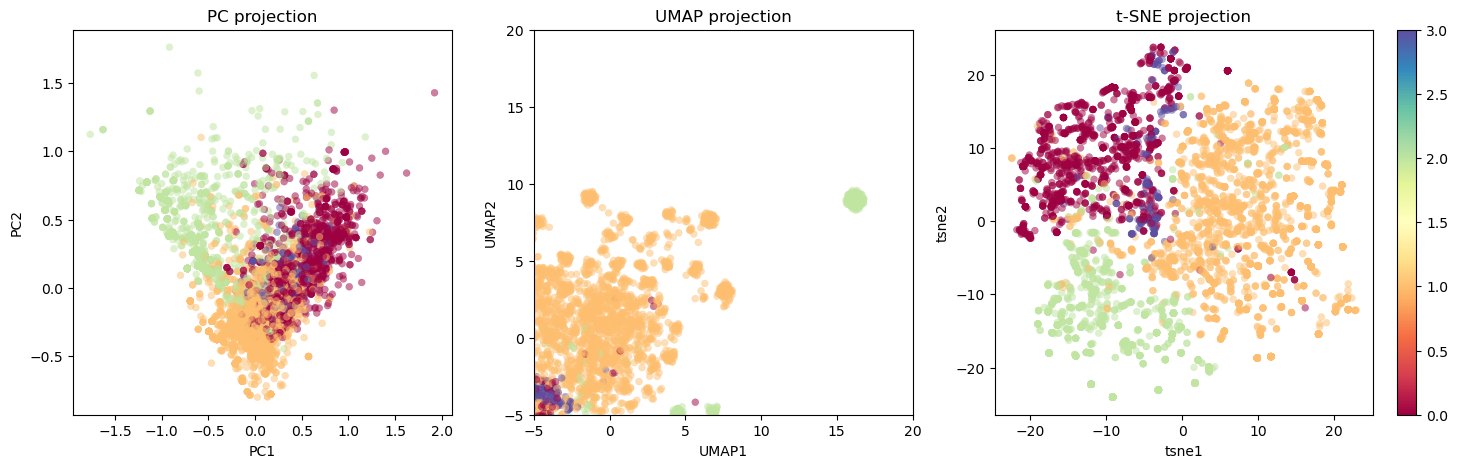

In [8]:
dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_pretrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embeddings_pretrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=64,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_pretrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_pretrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = np.array([scope_id2ind[id] for id in data.Halide])

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
print(scope_id2ind)
ax[2].figure.colorbar(sm)

ax[1].set_xlim((-5, 20))
ax[1].set_ylim((-5, 20))

plt.show()

In [10]:
# Reactivity and regioselectivity in Stille couplings of 3-substituted 2,4-dichloropyridines

smiles_list = [
    "C(Cl)1=CC=NC(Cl)=C1",
    "C(Cl)1=CC=NC(Cl)=C1",
    "C1(C(N)=C(Cl)N=CC=1)Cl",
    "C1(C(N)=C(Cl)N=CC=1)Cl",
    "C1(C=CN=C(Cl)C=1C(N)=O)Cl",
    "C1(C=CN=C(Cl)C=1C(N)=O)Cl",
    "C1(C(C=O)=C(Cl)N=CC=1)Cl",
    "C1(C(C=O)=C(Cl)N=CC=1)Cl",
    "C1(C=CN=C(Cl)C=1C(OC)=O)Cl",
    "C1(C=CN=C(Cl)C=1C(OC)=O)Cl",
    "C1(C(C#N)=C(Cl)N=CC=1)Cl",
    "C1(C(C#N)=C(Cl)N=CC=1)Cl",
    "C1(C=CN=C(Cl)C=1N(=O)=O)Cl",
    "C1(C=CN=C(Cl)C=1N(=O)=O)Cl",
    "C1(C([N+](=O)[O-])=C(Cl)N=C(Cl)C=1)Cl",
    "C1(C([N+](=O)[O-])=C(Cl)N=C(Cl)C=1)Cl",
    "C1(C([N+](=O)[O-])=C(Cl)N=C(Cl)C=1)Cl",
]

c_index_list = [
    5,
    0,
    3,
    0,
    4,
    0,
    4,
    0,
    4,
    0,
    4,
    0,
    4,
    0,
    5,
    0,
    8,
]

yield_list = [
    0.37,
    0.00,
    1.00,
    0.00,
    0.13,
    0.00,
    0.65,
    0.11,
    0.54,
    0.00,
    0.82,
    0.13,
    0.13,
    0.76,
    0.02,
    0.87,
    0.00,
]

site_list = [
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    0,
    0,
    1,
    0,
    1,
    0,
]


embeddings_selected = get_embedding_from_smi(smiles_list, c_index_list, model_pretrained, device)

dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_pretrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embeddings_pretrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=64,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_pretrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_pretrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = np.array([scope_id2ind[id] for id in data.Halide])

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
print(scope_id2ind)
ax[2].figure.colorbar(sm)

ax[1].set_xlim((-5, 20))
ax[1].set_ylim((-5, 20))

plt.show()

AttributeError: 'TSNE' object has no attribute 'transform'

{'Cl': 0, 'Br': 1, 'I': 2, 'F': 3}


/home/whgao/tmp/ipykernel_2827161/1574419435.py:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


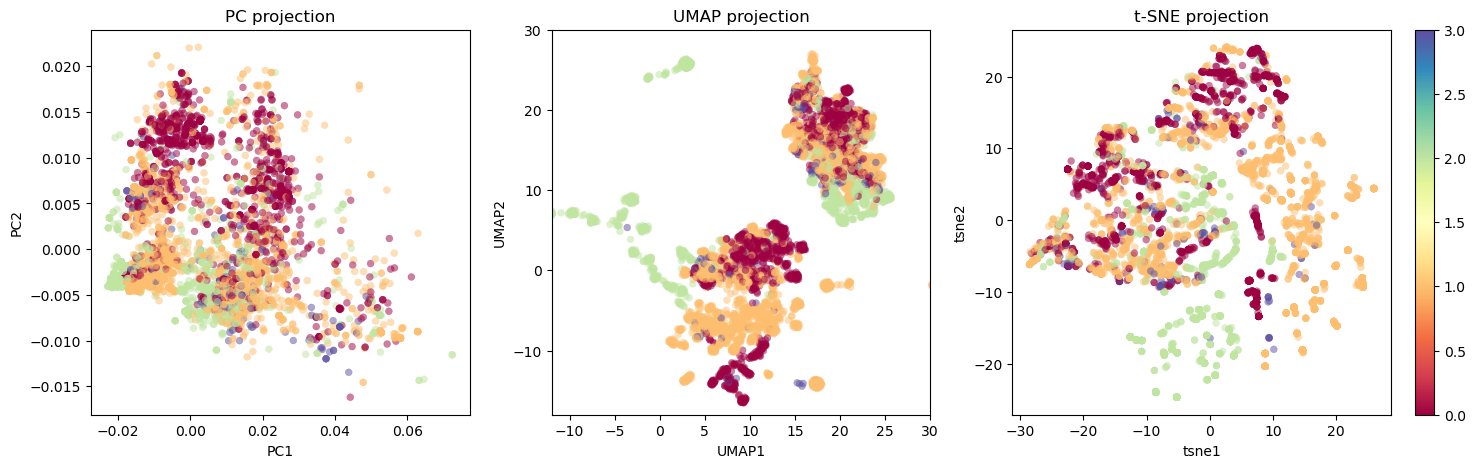

In [72]:
dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_untrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embeddings_untrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=64,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_untrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_untrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = np.array([scope_id2ind[id] for id in data.Halide])

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
print(scope_id2ind)
ax[2].figure.colorbar(sm)

ax[1].set_xlim((-12, 30))
ax[1].set_ylim((-18, 30))

plt.show()

# Hammett constant

In [ ]:
data = pd.read_csv(os.path.join(HOME_DIR, "data/Hammett.csv"))

patt_aryl_halide = Chem.MolFromSmarts('c-[Br]')
cx_indices = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in data.SMILES]

if config.pool == 'c':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind], 
                                                atm_idx=[cx_indices[ind][0]]) for ind in range(len(data))]
elif config.pool == 'cx':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind], 
                                            atm_idx=[cx_indices[ind][0], cx_indices[ind][1]]) for ind in range(len(data))]
elif config.pool == 'global':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind]) for ind in range(len(data))]
else:
    raise ValueError('Invalid pool type')
loader = DataLoader(train_dataset, 128, shuffle=False)

embeddings_pretrained = get_embedding(model_pretrained, loader, device)
embeddings_untrained = get_embedding(model_untrained, loader, device)

In [ ]:
dim = 2
dfs={}
# UMAP section

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=6, random_state=8).fit_transform(embeddings_pretrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=8,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_pretrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_pretrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

c_list = data['constant'].to_numpy()

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=35, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=35, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=35, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="gnuplot", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax[2].figure.colorbar(sm)

plt.show()

In [ ]:
dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_untrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=24, random_state=0).fit_transform(embeddings_untrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=25,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_untrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_untrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

c_list = data['constant'].to_numpy()

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="gnuplot", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax[2].figure.colorbar(sm)

plt.show()

# xTB

In [ ]:
data = pd.read_csv(os.path.join(HOME_DIR, "data/Hammett_xtb.csv"))

patt_aryl_halide = Chem.MolFromSmarts('c-[Br]')
cx_indices = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in data.SMILES]

if config.pool == 'c':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind], 
                                                atm_idx=[cx_indices[ind][0]]) for ind in range(len(data))]
elif config.pool == 'cx':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind], 
                                            atm_idx=[cx_indices[ind][0], cx_indices[ind][1]]) for ind in range(len(data))]
elif config.pool == 'global':
    train_dataset = [smiles_to_graph(smiles=data['SMILES'][ind], 
                                            y=data['constant'][ind]) for ind in range(len(data))]
else:
    raise ValueError('Invalid pool type')
loader = DataLoader(train_dataset, 128, shuffle=False)

embeddings_pretrained = get_embedding(model_pretrained, loader, device)
embeddings_untrained = get_embedding(model_untrained, loader, device)

In [ ]:
dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_pretrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=6, random_state=8).fit_transform(embeddings_pretrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=8,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_pretrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_pretrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

In [ ]:
data.columns

In [ ]:
c_list = data['fukui_nucleo_local'].to_numpy()

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=35, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=35, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=35, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="gnuplot", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax[2].figure.colorbar(sm)

plt.show()

In [ ]:
dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_untrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=24, random_state=0).fit_transform(embeddings_untrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=25,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_untrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_untrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

c_list = data['xtb_e_homo'].to_numpy()

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.8, linewidth=0.25, c=c_list, cmap='gnuplot', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="gnuplot", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax[2].figure.colorbar(sm)

plt.show()

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolHash
import rdkit
from rdkit.Chem import Draw

Mols = [Chem.MolFromSmiles(smiles) for smiles in data['SMILES']]
# Display molecules with labels
Draw.MolsToGridImage(Mols,legends=[str(label) for label in data.constant],molsPerRow=10,subImgSize=(150,150),useSVG=True)

# AutoQChem

In [5]:
data = pd.read_csv(os.path.join(HOME_DIR, "data/ah_selected_autoqchem.csv"))

train_dataset = [smiles_to_graph(smiles=data['smiles'][ind], 
                                        y=data['global_charge'][ind], 
                                            atm_idx=[data['c_index'][ind]]) for ind in range(len(data))]
loader = DataLoader(train_dataset, 128, shuffle=False)

embeddings_pretrained = get_embedding(model_pretrained, loader, device)
embeddings_untrained = get_embedding(model_untrained, loader, device)

{'I': 0, 'Br': 1, 'Cl': 2, 'F': 3}


/home/whgao/tmp/ipykernel_3310339/3127496670.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


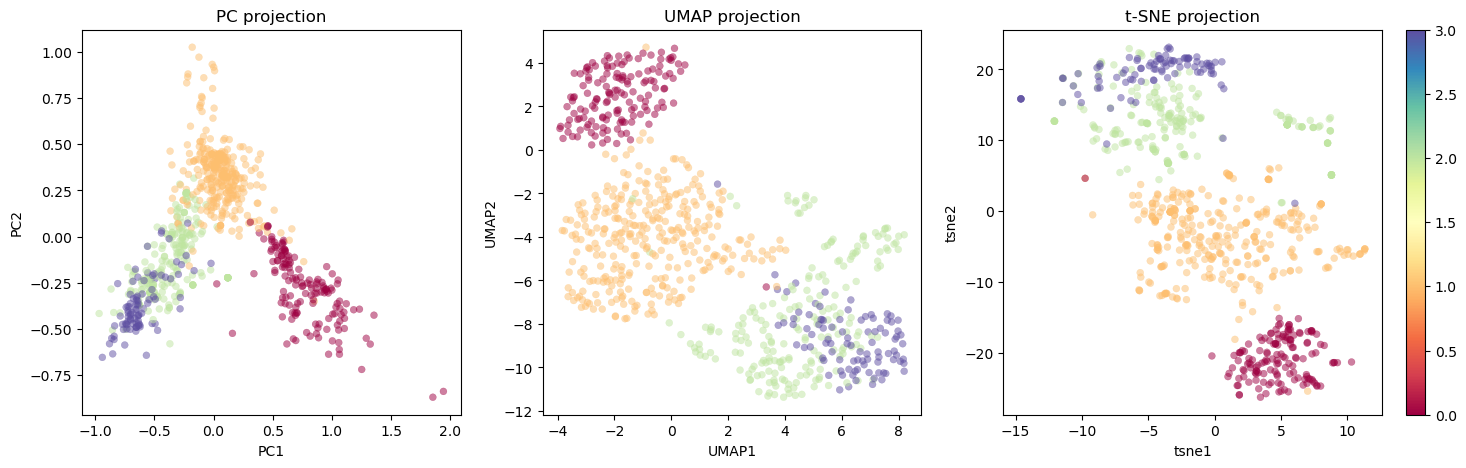

In [7]:
random.seed(0)
np.random.seed(0)

dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_pretrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embeddings_pretrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=64,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_pretrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_pretrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = np.array([scope_id2ind[id] for id in data.Halide])

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
print(scope_id2ind)
ax[2].figure.colorbar(sm)

# ax[1].set_xlim((-5, 20))
# ax[1].set_ylim((-5, 20))

plt.show()

In [8]:
random.seed(0)
np.random.seed(0)

dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_pretrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embeddings_pretrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=64,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_pretrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_pretrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

In [9]:
data.columns

Index(['smiles', 'c_index', 'x_index', 'global_number_of_atoms',
       'global_charge', 'global_multiplicity', 'global_dipole',
       'global_molar_mass', 'global_molar_volume',
       'global_electronic_spatial_extent', 'global_E_scf',
       'global_zero_point_correction', 'global_E_thermal_correction',
       'global_H_thermal_correction', 'global_G_thermal_correction',
       'global_E_zpe', 'global_E', 'global_H', 'global_G',
       'global_stoichiometry', 'global_converged', 'global_homo_energy',
       'global_lumo_energy', 'global_electronegativity', 'global_hardness',
       'global_ES_root_dipole', 'global_ES_root_molar_volume',
       'global_ES_root_electronic_spatial_extent', 'local_X', 'local_Y',
       'local_Z', 'local_VBur', 'local_Mulliken_charge', 'local_APT_charge',
       'local_NPA_charge', 'local_NPA_core', 'local_NPA_valence',
       'local_NPA_Rydberg', 'local_NPA_total', 'local_NMR_shift',
       'local_NMR_anisotropy', 'local_ES_root_Mulliken_charge',
     

/home/whgao/tmp/ipykernel_3310339/2901083364.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


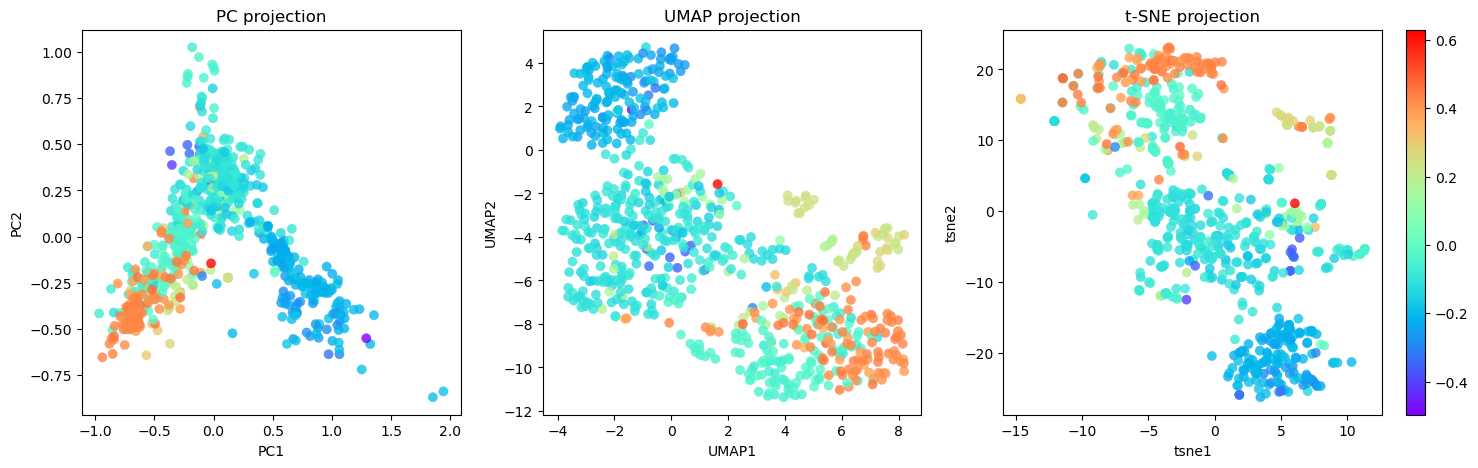

In [10]:
c_list = data['local_NPA_charge'].to_numpy()

# scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
# c_list = np.array([scope_id2ind[id] for id in data.Halide])

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
fig = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=45, alpha=0.8, linewidth=0.25, c=c_list, cmap='rainbow', edgecolor='face', ax=ax[0]).set_title("PC projection") 
fig = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=45, alpha=0.8, linewidth=0.25, c=c_list, cmap='rainbow', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
fig = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=45, alpha=0.8, linewidth=0.25, c=c_list, cmap='rainbow', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax[2].figure.colorbar(sm)

plt.show()

In [11]:
data[data['smiles'].apply(lambda x: '([O-])=O)' in x and 'Br' in x)][data['from_hammett']]

/home/whgao/tmp/ipykernel_3310339/2920784758.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['smiles'].apply(lambda x: '([O-])=O)' in x and 'Br' in x)][data['from_hammett']]


,smiles,c_index,x_index,global_number_of_atoms,global_charge,global_multiplicity,global_dipole,global_molar_mass,global_molar_volume,global_electronic_spatial_extent,...,local_ES_root_NPA_charge,local_ES_root_NPA_core,local_ES_root_NPA_valence,local_ES_root_NPA_Rydberg,local_ES_root_NPA_total,from_cas,from_hammett,from_informer,local_NMR_pred,Halide
8,Brc1ccc([N+]([O-])=O)cc1,1,0,14.0,0.0,1.0,3.3141,202.0071,1100.623,2739.5325,...,-0.12770,1.99862,4.10746,0.02162,6.12770,True,True,False,126.147856,Br
67,Brc1c([N+]([O-])=O)cccc1,1,0,14.0,0.0,1.0,4.6046,202.0071,1004.617,1856.2300,...,-0.14744,1.99850,4.12774,0.02120,6.14744,True,True,False,108.166375,Br
71,Brc1cccc([N+]([O-])=O)c1,1,0,14.0,0.0,1.0,4.0404,202.0071,1284.479,2437.6707,...,-0.10091,1.99861,4.07997,0.02233,6.10091,True,True,False,117.174953,Br


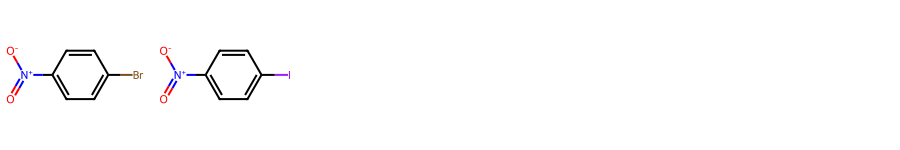

In [12]:
ind = 8
# Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in data[data['from_hammett']].smiles.to_list()[:48]], molsPerRow=6,subImgSize=(150,150),useSVG=True)
# Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in data.smiles.to_list()[:48]], molsPerRow=6,subImgSize=(150,150),useSVG=True)
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in data.smiles.to_list()[ind:ind+2]], molsPerRow=6,subImgSize=(150,150),useSVG=True)

In [6]:
select_list = np.array([73, 100, 504, 75, 4, 510, 5, 2, 69, 23, 10, 8])[[0, 2, 1, 4, 5, 3, 6, 7, 9, 10, 8, 11]]
# select_list = np.array([73, 100, 504, 75, 4, 510, 5, 2, 69, 23, 10, 8])[[7, 2, 3, 6, 1, 4, 5, 8, 11, 0, 9, 10]]
# temp = embeddings_pretrained[data['from_hammett']][select_list]
temp = embeddings_pretrained[select_list]

In [10]:
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.DataManip.Metric import GetTanimotoDistMat

def converter(smiles_list):
    fps = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        fps.append(fp)
    return fps

def dismat(fps):
    n = len(fps)
    arr = np.zeros([n, n])
    for i in range(n):
        for j in range(i):
            dist = 1 - DataStructs.TanimotoSimilarity(fps[i],fps[j])
            arr[i][j] = dist
            arr[j][i] = dist
    return arr

fps = converter(data.smiles.to_numpy()[select_list])
# DataStructs.TanimotoSimilarity(fps[0],fps[1])

dist_mat = dismat(fps)

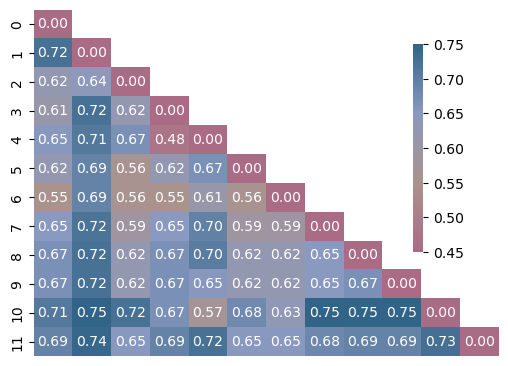

In [11]:
a = 0.75
fig, ax = plt.subplots(figsize=(10*a, 6*a))

hex_colors = [
    'aa6b85', 'aa938d', '8a99bf', '316487'
]


# Convert hex color values to RGB values
rgb_colors = [tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)) for hex_color in hex_colors]

# Normalize the RGB values to the range 0-1 (required by matplotlib)
rgb_normalized = [(r/255, g/255, b/255) for r, g, b in rgb_colors]

# Now we'll create a colormap from the list of normalized RGB values.
from matplotlib.colors import LinearSegmentedColormap

custom_colormap = LinearSegmentedColormap.from_list('custom_cmap', rgb_normalized)


matrix = np.triu(np.ones_like(dist_mat, dtype=bool))
np.fill_diagonal(matrix, False)
sns.heatmap(dist_mat, annot=True, mask=matrix, fmt='.2f', ax=ax, cmap=custom_colormap, xticklabels=False, yticklabels="auto",
            cbar_kws={'shrink': 0.6, 'location': 'right', 'anchor': (-1.5, 0.75), 'format': "{x:.2f}", 'spacing': 'proportional'}, vmin=0.45, vmax=0.75)
# plt.show()
save_fig(ax, 'pair_dist_tanimoto.pdf')
# plt.savefig('pair_dist_tanimoto.png', dpi=800, bbox_inches='tight', transparent=True)

In [12]:
def snr_distance(ri, rj):
    return np.var(ri - rj) / np.var(ri)

snr_distance(temp[1], temp[0])

0.46561587

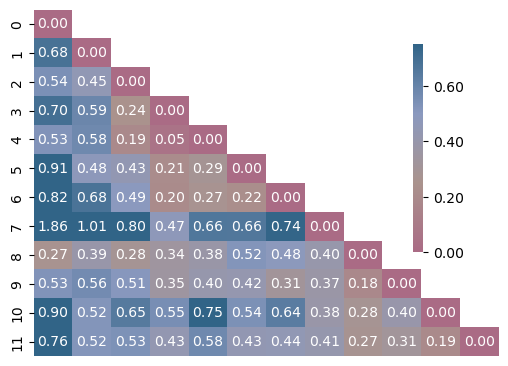

In [13]:
dist_mat_learned = sklearn.metrics.pairwise_distances(temp, metric=snr_distance)
a = 0.75
fig, ax = plt.subplots(figsize=(10*a, 6*a))
matrix = np.triu(np.ones_like(dist_mat_learned, dtype=bool))
np.fill_diagonal(matrix, False)
sns.heatmap(dist_mat_learned, annot=True, mask=matrix, fmt='.2f', ax=ax, cmap=custom_colormap, xticklabels=False, yticklabels="auto",
            cbar_kws={'shrink': 0.6, 'location': 'right', 'anchor': (-1.5, 0.75), 'format': "{x:.2f}", 'spacing': 'proportional'}, vmin=0, vmax=0.75)
# set the range of color bar in seaborn

save_fig(ax, 'pair_dist_learned.pdf')
# plt.show()
# plt.savefig('pair_dist_learned.png', dpi=800, bbox_inches='tight', transparent=True)

In [145]:
# Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in data[data['from_hammett']].smiles.to_numpy()[select_list]], molsPerRow=6,subImgSize=(150,150),useSVG=True,legends=[str(i) for i in range(len(select_list))])
img = Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in data.smiles.to_numpy()[select_list]], molsPerRow=4,subImgSize=(200,200),legends=[str(i) for i in range(len(select_list))])
with open("pair_dist_mols_rerodered.png", "wb") as png:
    png.write(img.data)  

In [51]:
temp.shape

(12, 64)

In [16]:
i = Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in data.smiles.to_numpy()[select_list]], molsPerRow=4,subImgSize=(200,200),legends=[str(i) for i in range(len(select_list))])
with open("visualization_Hammet_molecules.png", "wb") as png:
    png.write(i.data)

<Axes: >

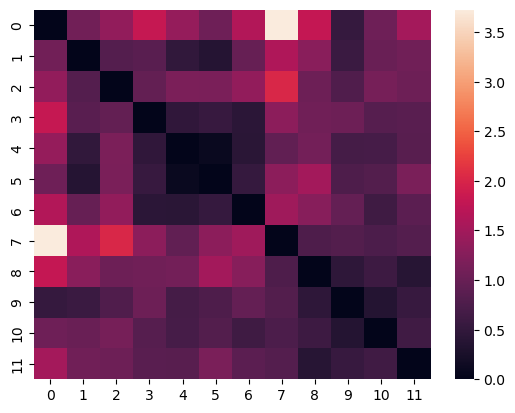

In [130]:
sns.heatmap(dist_mat_learned)

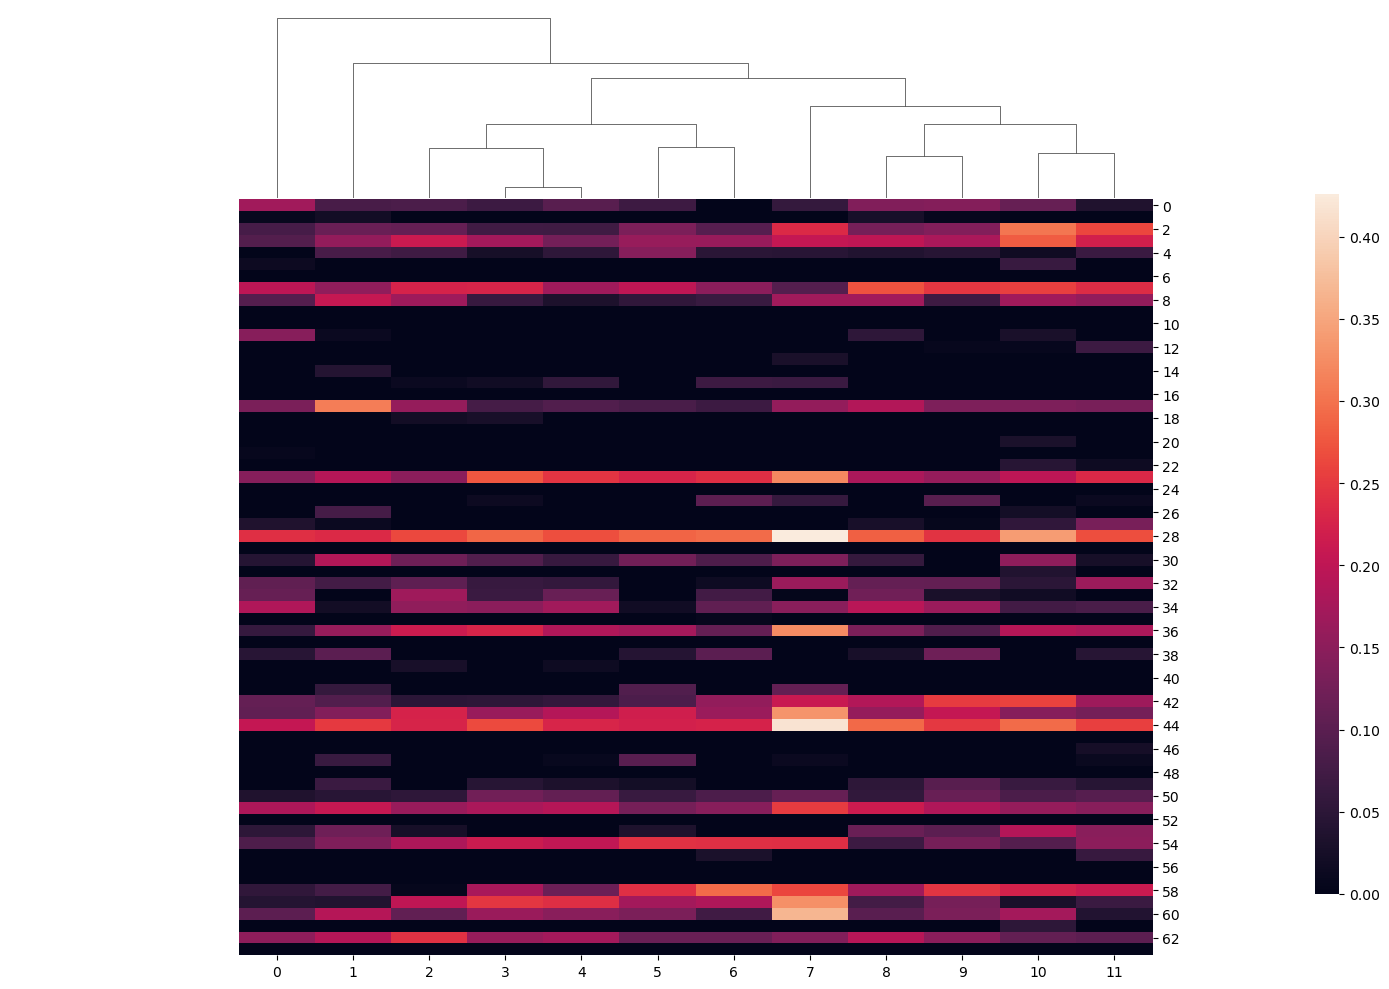

In [23]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

linkage = hc.linkage(sp.distance.squareform(dist_mat_learned), method='average')

sns.clustermap(
    temp.T,
    figsize=(12, 10),
    row_cluster=False,
    col_linkage=linkage, 
    cbar_kws={"orientation": 'vertical'},
    cbar_pos=(1.1, 0.1, .02, .7)
)

plt.savefig('bits_cluster_viz.pdf', dpi=800, bbox_inches='tight', transparent=True)

In [81]:
snr_distance(temp[0], temp[1])

TypeError: var() received an invalid combination of arguments - got (numpy.ndarray), but expected one of:
 * (Tensor input, tuple of ints dim, bool unbiased, bool keepdim, *, Tensor out)
 * (Tensor input, tuple of ints dim, *, int correction, bool keepdim, Tensor out)
 * (Tensor input, bool unbiased)
 * (Tensor input, tuple of names dim, bool unbiased, bool keepdim, *, Tensor out)
 * (Tensor input, tuple of names dim, *, int correction, bool keepdim, Tensor out)


In [ ]:
# Transposing the data matrix for rotation
transposed_temp = temp.T

# Generating a linkage matrix for the transposed matrix
# Note: We use a different linkage for the columns since the matrix is transposed
col_linkage = hc.linkage(sp.distance.squareform(sym_dist_mat), method='average')

# Creating a clustermap with the transposed matrix
clustermap_rotated = sns.clustermap(
    transposed_temp,
    figsize=(4, 10),  # Adjusting the figure size for the rotation
    row_cluster=False,
    col_linkage=col_linkage, 
    cbar_kws={"orientation": 'vertical'},  # Adjusting the orientation of the color bar
    cbar_pos=(0.9, 0.25, .02, .7)
)

# Saving th

# Buyable

In [16]:
data_buyable = pd.read_csv("../data/buyable_aryl_bromides.csv")
data_buyable

,smiles,c_index,x_index,in_doyle,informer
0,BrC1=CC=C(C=O)C=C1,1,0,False,False
1,BrC1=CC=CC=C1,1,0,False,False
2,CC(=O)C1=CC=C(Br)C=C1,6,7,False,False
3,COC1=CC=C(Br)C=C1,5,6,False,False
4,CC1=CC=C(Br)C=C1,4,5,False,False
...,...,...,...,...,...
2694,IC1=C(F)C=C(N2C[C@H](CN3C=CN=N3)OC2=O)C=C1,1,0,False,True
2695,IC1=CC=C(N=C(CCC)N(CC2=CC=C(C3=C(S(=O)(NC(C)(C...,1,0,False,True
2696,ClC1=CC2=C([C@H](C(NC(C)=O)(C)C)CC23CCN(C(OC(C...,1,0,False,True
2697,ClC1=CC=C(NC(O[C@]2(C#CC3CC3)C(F)(F)F)=O)C2=C1,1,0,False,True


In [57]:
test_doyle_smiles = [
    "C(Br)1=CC(C2OC(C=O)=CC=2)=CC=C1",
    "C(Br)1=CC(C2=CC=C(F)C=C2)=CC=C1",
    "C1=C(F)C(OC)=CC(C)=C1Br",
    "C(C#N)1=CC=C(OC)C=C1Br",
    "C1=CC(S(=O)(N2CCOCC2)=O)=CC=C1Br",
    "C1=C(S(=O)(C)=O)C=CC(C)=C1Br",
    "C1=CC(N2CCN(C(=O)OC(C)(C)C)CC2)=C(Cl)C=C1Br",
    "C1=C(C#N)C(F)=CC=C1Br",
    "C1=CC(C(=O)CCC(=O)OC)=CC=C1Br",
    "C1=CC(C2=CNC=N2)=CC=C1Br",
    "C(COC)1=CC=CC(OC)=C1Br",
    "C(Cl)1=CC=C(C(C)(C)C)C=C1Br",
    "C1=C(OC(F)(F)F)C=C(Cl)C=C1Br",
    "C1=CC=C(C(=O)OCC)C(C)=C1Br",
    "C(F)1=CC=C(C(C)(C)C)C=C1Br"
]

test_doyle_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles)) for smiles in test_doyle_smiles]

In [12]:
embedding_buyable = get_embedding_from_smi(
    data_buyable.smiles.to_list(),
    data_buyable.c_index.to_list(),
    model_pretrained,
    device
)

/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


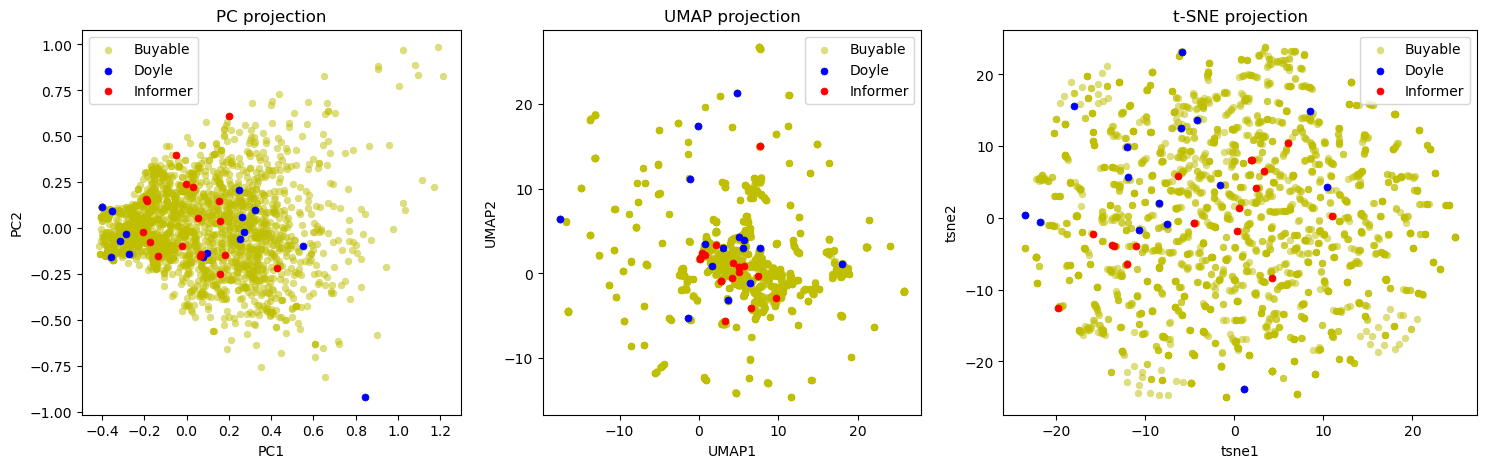

In [14]:
dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embedding_buyable.shape[1]))

key = f"umap{dim}"
n_neighbors = 6
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors, random_state=8).fit_transform(embedding_buyable), index=data_buyable.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=8,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embedding_buyable), index=data_buyable.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embedding_buyable), index=data_buyable.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

# scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = data_buyable.in_doyle.to_list()
# c_list = None

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']

_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'][~data_buyable.in_doyle], s=25, alpha=0.5, linewidth=0.25, c='y', edgecolor='face', ax=ax[0], label="Buyable").set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'][~data_buyable.in_doyle], s=25, alpha=0.5, linewidth=0.25, c='y', edgecolor='face', ax=ax[1], label="Buyable").set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'][~data_buyable.in_doyle], s=25, alpha=0.5, linewidth=0.25, c='y', edgecolor='face', ax=ax[2], label="Buyable").set_title("t-SNE projection")

_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'][data_buyable.in_doyle], s=25, alpha=1.0, linewidth=0.5, c='b', edgecolor='face', ax=ax[0], label="Doyle").set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'][data_buyable.in_doyle], s=25, alpha=1.0, linewidth=0.5, c='b', edgecolor='face', ax=ax[1], label="Doyle").set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'][data_buyable.in_doyle], s=25, alpha=1.0, linewidth=0.5, c='b', edgecolor='face', ax=ax[2], label="Doyle").set_title("t-SNE projection")

_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'][data_buyable.informer], s=25, alpha=1.0, linewidth=0.5, c='r', edgecolor='face', ax=ax[0], label="Informer").set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'][data_buyable.informer], s=25, alpha=1.0, linewidth=0.5, c='r', edgecolor='face', ax=ax[1], label="Informer").set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'][data_buyable.informer], s=25, alpha=1.0, linewidth=0.5, c='r', edgecolor='face', ax=ax[2], label="Informer").set_title("t-SNE projection")

# norm = plt.Normalize(0, 1)
# sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
# sm.set_array([])

# Remove the legend and add a colorbar
# print(scope_id2ind)
# ax[2].figure.colorbar(sm)
plt.legend()
plt.show()

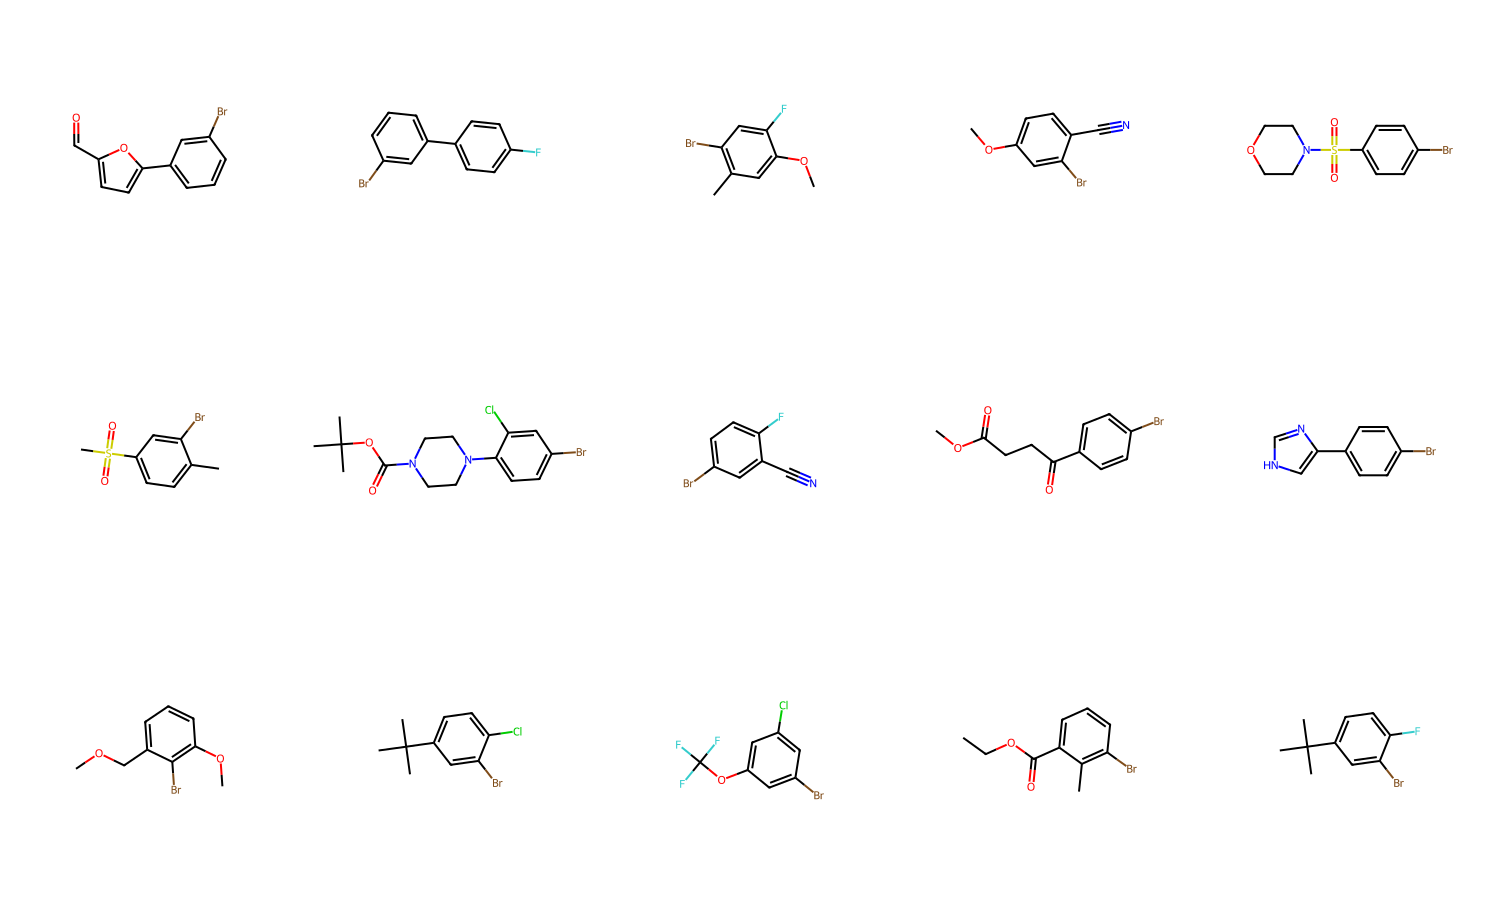

In [53]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in test_doyle_smiles], molsPerRow=5,subImgSize=(300,300),useSVG=True)